In [1]:
!wget https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/master/data/nantes_2020-05-20_198328.zip -O /tmp/old.zip
!wget https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/master/data/nantes_2020-05-22_198605.zip -O /tmp/new.zip

--2020-06-05 14:39:19--  https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/master/data/nantes_2020-05-20_198328.zip
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 11383542 (11M) [application/zip]
Sauvegarde en : « /tmp/old.zip »

/tmp/old.zip        100%[===================>]  10,86M  28,7MB/s    ds 0,4s    

2020-06-05 14:39:20 (28,7 MB/s) — « /tmp/old.zip » sauvegardé [11383542/11383542]

--2020-06-05 14:39:20--  https://gitlab.in2p3.fr/cornebize/g5k_data_non_regression/-/raw/master/data/nantes_2020-05-22_198605.zip
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 11638690 (11M) [application/zip]
Sauvegarde en : « /tmp/new.zip »

/tmp/new.zip        100%[=======

In [2]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

archives = ['/tmp/old.zip', '/tmp/new.zip']

f6e1abe82ebba1eec668652189985c631c10b5b5


In [3]:
df = pandas.concat([ae.read_performance(f) for f in archives])
df = df[df.node == 24].copy()
df['mnk'] = df.m * df.n * df.k
df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
df['cpu_id'] = df['node'].astype(str) + ':' + df['cpu'].astype(str)
df['date'] = pandas.to_datetime(df['start_time'], unit='s').astype(str)
print(len(df))
df.head()

21800


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,mnk,gflops,cpu_id,date
239800,dgemm,10028,1418,562,290.785413,0.776881,0,24,ecotype,198328,0,1589955290,11990,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7991473648,20.573214,24:0,2020-05-20 06:14:50
239801,dgemm,2694,913,3118,291.562318,0.770534,0,24,ecotype,198328,0,1589955290,11991,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7669101396,19.905934,24:0,2020-05-20 06:14:50
239802,dgemm,1375,1143,1491,292.332862,0.242274,0,24,ecotype,198328,0,1589955290,11992,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2343292875,19.344179,24:0,2020-05-20 06:14:50
239803,dgemm,3605,8615,236,292.575144,0.717722,0,24,ecotype,198328,0,1589955290,11993,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7329469700,20.424258,24:0,2020-05-20 06:14:50
239804,dgemm,1540,2443,2124,293.292876,0.817267,0,24,ecotype,198328,0,1589955290,11994,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,7990955280,19.555306,24:0,2020-05-20 06:14:50


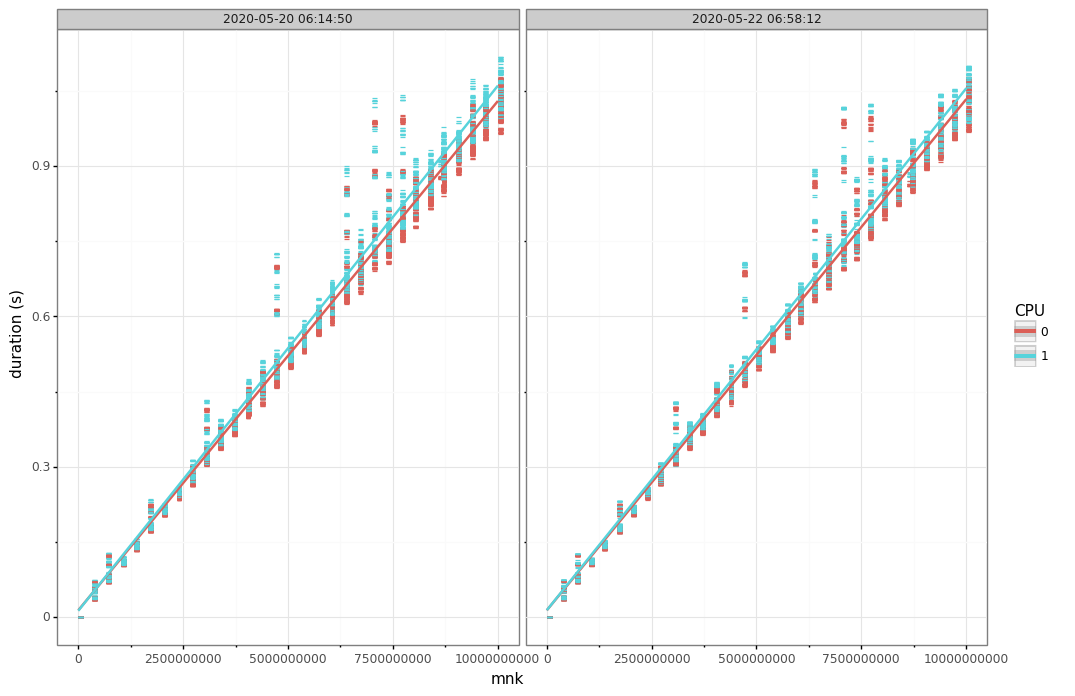

<ggplot: (-9223363305986325195)>

In [4]:
ggplot(df) +\
    aes(x='mnk', y='duration', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    geom_smooth(method='lm') +\
    facet_wrap('date') +\
    ylab('duration (s)') +\
    labs(color="CPU") +\
    theme_bw()

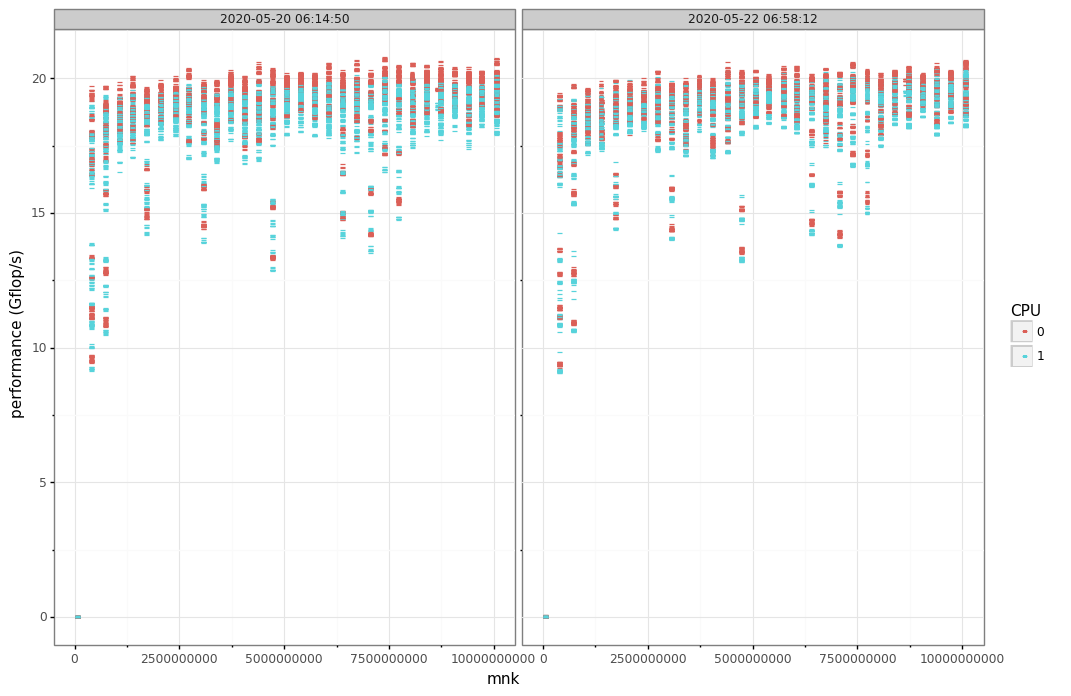

<ggplot: (8730859518072)>

In [5]:
ggplot(df) +\
    aes(x='mnk', y='gflops', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('date') +\
    ylab('performance (Gflop/s)') +\
    labs(color="CPU") +\
    theme_bw()

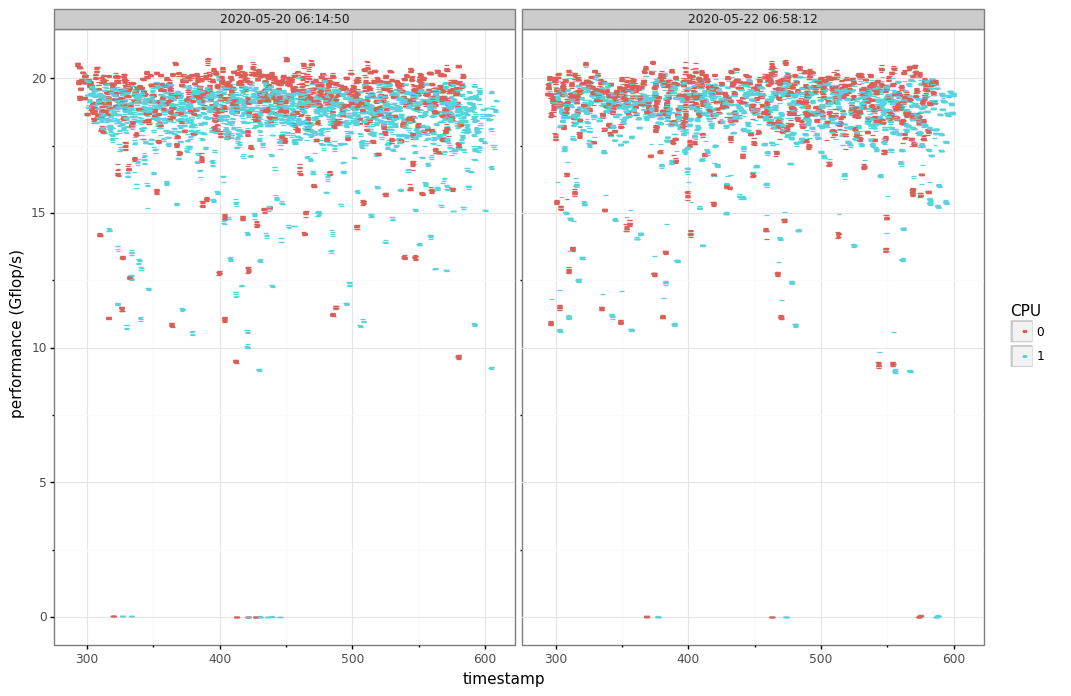

<ggplot: (-9223363305996417876)>

In [6]:
ggplot(df) +\
    aes(x='timestamp', y='gflops', color='factor(cpu)', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('date') +\
    ylab('performance (Gflop/s)') +\
    labs(color='CPU') +\
    theme_bw()

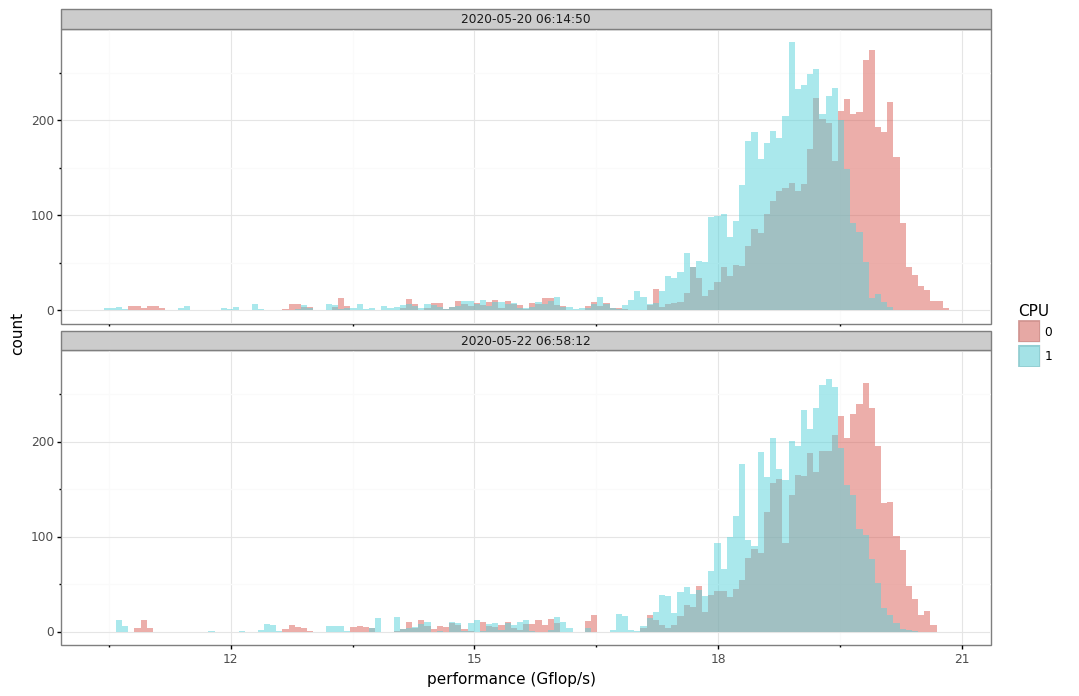

<ggplot: (8730857046150)>

In [7]:
ggplot(df[df.duration > 0.1]) +\
    aes(x='gflops', fill='factor(cpu)', group='cpu_id') +\
    geom_histogram(position="identity", alpha=0.5) +\
    facet_wrap('date', nrow=2) +\
    xlab('performance (Gflop/s)') +\
    labs(fill="CPU") +\
    theme_bw()

In [8]:
monitoring = pandas.concat([ae.read_monitoring(f) for f in archives])
monitoring = monitoring[monitoring.node == 24].reset_index(drop=True)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'timestamp'] = monitoring['timestamp'] - monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
print(len(monitoring))
monitoring.head()

13240


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,date,cpu_id
0,0.000000,ecotype,24,198328,1589955290,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.868530,0,0,frequency,1.589964e+09,1.589965e+09,2020-05-20 06:14:50,24:0
1,10.014677,ecotype,24,198328,1589955290,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.999951,0,0,frequency,1.589964e+09,1.589965e+09,2020-05-20 06:14:50,24:0
2,20.058652,ecotype,24,198328,1589955290,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.999951,0,0,frequency,1.589964e+09,1.589965e+09,2020-05-20 06:14:50,24:0
3,30.089691,ecotype,24,198328,1589955290,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.200476,0,0,frequency,1.589964e+09,1.589965e+09,2020-05-20 06:14:50,24:0
4,40.110202,ecotype,24,198328,1589955290,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.805139,0,0,frequency,1.589964e+09,1.589965e+09,2020-05-20 06:14:50,24:0


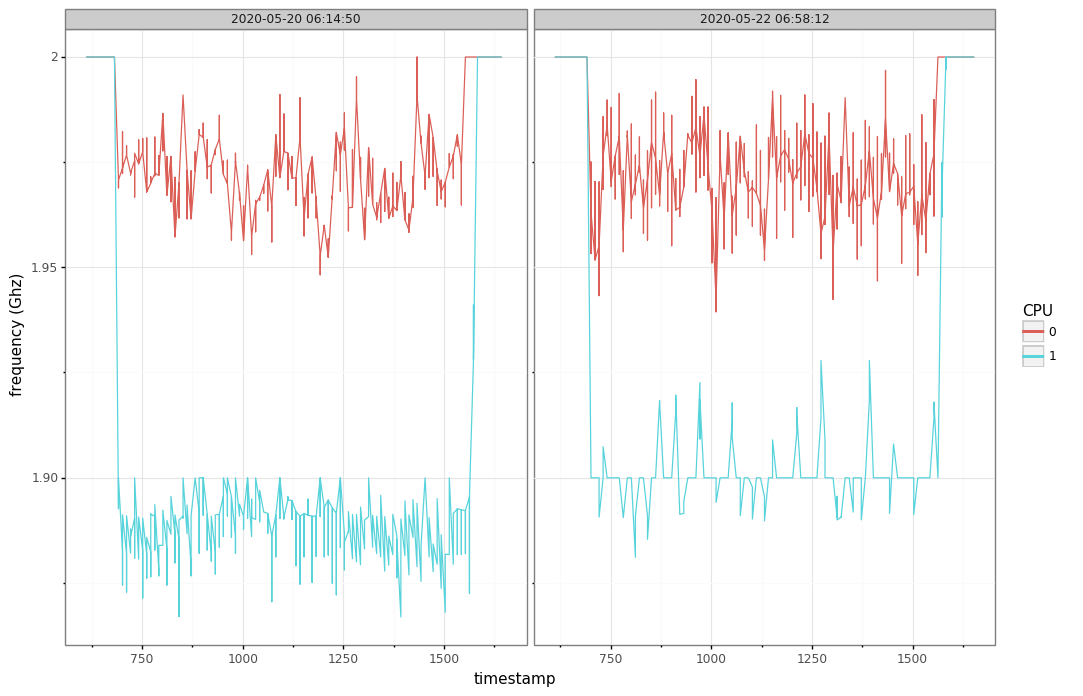

<ggplot: (-9223363305997972827)>

In [9]:
ggplot(monitoring[(monitoring['kind'] == 'frequency') & (monitoring['timestamp'] > df['timestamp'].min()) & (monitoring['timestamp'] > df['timestamp'].max())]) +\
    aes(x='timestamp', y='value', color='factor(cpu)', group='cpu_id') +\
    geom_line() +\
    facet_wrap('date') +\
    ylab('frequency (Ghz)') +\
    labs(color='CPU') +\
    theme_bw()

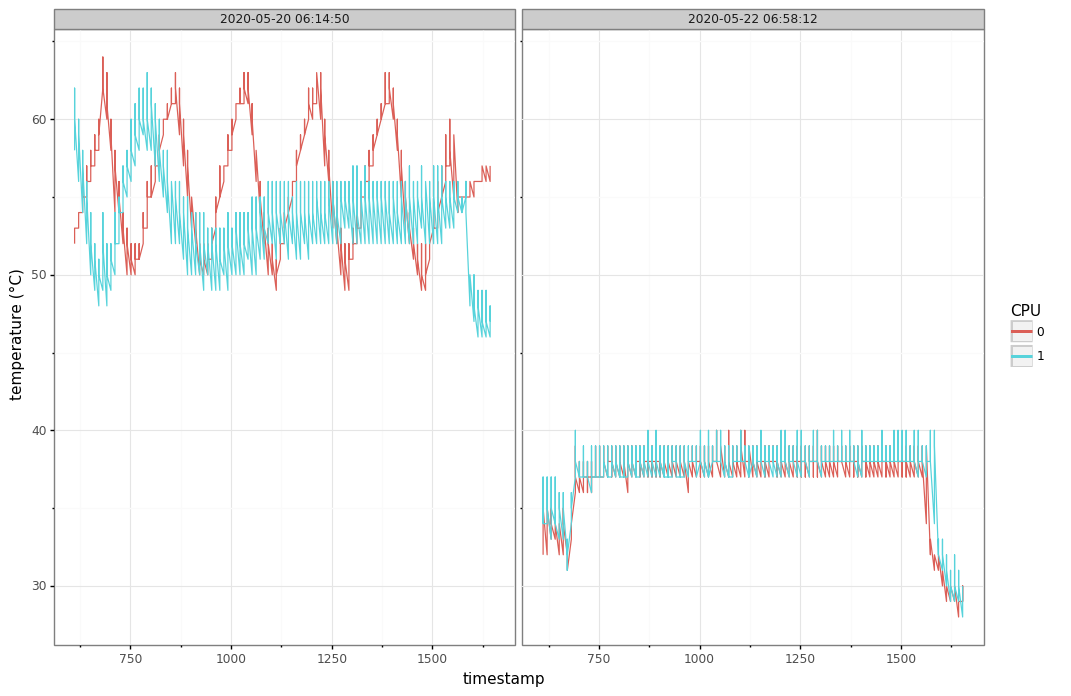

<ggplot: (8730856978394)>

In [10]:
ggplot(monitoring[(monitoring['kind'] == 'temperature') & (monitoring['timestamp'] > df['timestamp'].min()) & (monitoring['timestamp'] > df['timestamp'].max())]) +\
    aes(x='timestamp', y='value', color='factor(cpu)', group='cpu_id') +\
    geom_line() +\
    facet_wrap('date') +\
    ylab('temperature (°C)') +\
    labs(color='CPU') +\
    theme_bw()